# Face Recognition Encoder training used Triplet Loss

The following codes were based on https://github.com/rohanrao619/Face_Recognition_using_Siamese_Network<br>
Author: Yihe Yang, Wenduren, Weibin Yuan, Ruilin Xia and Ao Li   <br>
Created time: 2020.8 <br>
Last updated time: 2020.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os,pickle
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray
# from mtcnn.mtcnn import MTCNN
from keras.models import Model,model_from_json,load_model
from keras.layers import Layer,Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import keras.backend as K

## 加载数据集

In [ ]:
# Load dataset
# 加载数据集
train_path_ = "drive/My Drive/Face_recognation/train_batch_cropped"
with open(train_path_, 'rb')as f:
  data = pickle.load(f)
face_labels = data['label']
names = data['names']
cropped_faces = data['faces']
del data

In [ ]:
# Count the id number
# 数据集中的人数
n_IDs = len(np.unique(face_labels))
print(n_IDs)
print(face_labels.shape,len(names),cropped_faces.shape)

283
(1698,) 1698 (1698, 100, 80, 3)


## 样本间距离计算方法

In [ ]:
# Calculate the euclidian distance between two faces
# 两个样本之间的欧式距离

def distance(a,b):

  a/= np.sqrt(np.maximum(np.sum(np.square(a)),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b)),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b)))

  return dist

In [ ]:
# Calculate the euclidian distance between two batch of faces 
# 两个batch之间的欧式距离

def distance_batch(a,b):

  a/= np.sqrt(np.maximum(np.sum(np.square(a),axis=1,keepdims=True),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b),axis=1,keepdims=True),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b),axis=1))

  return dist

In [ ]:
# Calculate the distance between anchor and each face in a batch
# 计算一张图像和一簇图像之间的距离，用于寻找和给定图像最近和最远距离的图像
def distance_anchor(anchor,batch,id=0):

  anchor/= np.sqrt(np.maximum(np.sum(np.square(anchor)),1e-10))
  batch/= np.sqrt(np.maximum(np.sum(np.square(batch),axis=1,keepdims=True),1e-10))
  
  anchor = anchor.reshape(128)
  dist = np.sqrt(np.sum(np.square(anchor-batch),axis=1))

  if id==0:
    return np.argmax(dist)
  else:
    return np.argmin(dist)

In [ ]:
# Function to normalize a Single face

def normalize_single(X):

  axis = (0,1,2)

  mean = np.mean(X,axis)
  std = np.std(X,axis)

  size= X.size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [ ]:
# Function to normalize a Batch of faces

def normalize_batch(X):

  axis = (1,2,3)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [ ]:
# Function to normalize a Triplet batch

def normalize_triplet_batch(X):

  axis = (2,3,4)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0][0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return [X[0],X[1],X[2]]

## 构建Training batch
 生成一组形如 ( Anchor-Positive-Negative ) 的三元组

### Triplet选取方法 1
严格计算 Hard Negative

In [ ]:
def get_batch(batch_size, numk=10):

  X_anchor_samples = np.array([face for face in cropped_faces])
  # filter = np.random.choice(list(range(0,X_anchor_samples.shape[0])),int(batch_size))
  filter = [72,183,201]
  X_anchor_batch = []
  X_positive_samples = []
  X_negative_samples = []

  for i in filter:
    index = int(i/10)
    X_positives = X_anchor_samples[index*numk:(index+1)*numk]
    j=i%10
    # print(i,j,index*numk,(index+1)*numk)
    X_anchor = X_positives[j]
    X_anchor_batch.append(X_anchor)
    X_anchor_vec = enc_model.predict(np.array([normalize_single(X_anchor)]))
    
    X_positive = np.concatenate((X_positives[:j],X_positives[j+1:]))
    index_positive = distance_anchor(X_anchor_vec,enc_model.predict(normalize_batch(X_positive)))
    X_positive_samples.append(X_positive[index_positive])

    X_negative = np.concatenate((X_anchor_samples[:index*numk-1],X_anchor_samples[numk*(index+1)+1:]))
    index_negative = distance_anchor(X_anchor_vec,enc_model.predict(normalize_batch(X_negative)),id=-1)
    # print(index*numk,numk*(index+1)+1,index_negative)
    X_negative_samples.append(X_negative[index_negative])
  
  X_anchor_batch = np.array(X_anchor_batch)
  X_positive_samples = np.array(X_positive_samples)
  X_negative_samples = np.array(X_negative_samples)  

  return [X_anchor_batch,X_positive_samples,X_negative_samples]

### Triplet选择方法 2
随机选择positive和negative样本

In [ ]:
def get_batch_randomly(batch_size, numk=6):
  X_anchor = np.array([i for i in range(n_IDs)])
  # 随机选择batch_size个图像作为样本
  filter = np.random.choice(X_anchor,int(batch_size))
  X_anchor_batch = []
  X_positive_samples = []
  X_negative_samples = []

  for index in filter:
    X_positives = cropped_faces[index*numk:(index+1)*numk]
    X_anchor = X_positives[0]
    k=np.random.randint(1,numk)

    X_anchor_batch.append(X_anchor)
    X_positive_samples.append(X_positives[k])

    k2 = np.random.randint(n_IDs)
    while k2>=index*numk and k2<(index+1)*numk+1:
      k2 = np.random.randint(n_IDs)
    X_negative_samples.append(cropped_faces[k2])
  
  X_anchor_batch = np.array(X_anchor_batch)
  X_positive_samples = np.array(X_positive_samples)
  X_negative_samples = np.array(X_negative_samples)  
  return [X_anchor_batch,X_positive_samples,X_negative_samples]

### Triplet选取方法 3
负采样

In [ ]:
def get_batch_negative_sampling(batch_size, numk=6, negative_sampling=10):

  X_anchor_samples = np.array([face for face in cropped_faces])
  filter = np.random.choice(list(range(0,X_anchor_samples.shape[0])),int(batch_size))
  # filter=[72,183,201]
  X_anchor_batch = []
  X_positive_samples = []
  X_negative_samples = []

  for i in filter:
    index = int(i/numk)
    X_positives = X_anchor_samples[index*numk:(index+1)*numk]
    j=i%numk
    # print(i,j,index*numk,(index+1)*numk)
    X_anchor = X_positives[j]
    X_anchor_batch.append(X_anchor)
    X_anchor_vec = enc_model.predict(np.array([normalize_single(X_anchor)]))
    
    X_positive = np.concatenate((X_positives[:j],X_positives[j+1:]))
    index_positive = distance_anchor(X_anchor_vec,enc_model.predict(normalize_batch(X_positive)))
    X_positive_samples.append(X_positive[index_positive])

    filter_negative = []
    for j in range(negative_sampling):
      k = np.random.randint(len(X_anchor_samples))
      while k>index*numk and k<(index+1)*numk:
        k = np.random.randint(len(X_anchor_samples))
      filter_negative.append(k)

    X_negative = X_anchor_samples[filter_negative]
    index_negative = distance_anchor(X_anchor_vec,enc_model.predict(normalize_batch(X_negative)),id=-1)
    # print(index*numk,numk*(index+1)+1,index_negative)
    X_negative_samples.append(X_negative[index_negative])
  
  X_anchor_batch = np.array(X_anchor_batch)
  X_positive_samples = np.array(X_positive_samples)
  X_negative_samples = np.array(X_negative_samples)  

  return [X_anchor_batch,X_positive_samples,X_negative_samples]

### Triplet选取方法 4
25%的随机三元组+75%的难样例三元组

In [ ]:
def get_batch_sort(n_rand_triplets=30,n_hard_triplets=88):
  X_anchor_random, X_positive_random, X_negative_random = get_batch_randomly(n_rand_triplets)
  X_anchor_hard, X_positive_hard, X_negative_hard = get_batch_negative_sampling(n_hard_triplets)


  # Concatenate to form a Triplet batch of required size
  # 组合两种三元组

  X_anchor_batch  = np.concatenate((X_anchor_random,X_anchor_hard))
  X_positive_batch = np.concatenate((X_positive_random,X_positive_hard))
  X_negative_batch = np.concatenate((X_negative_random,X_negative_hard))

  return [X_anchor_batch,X_positive_batch,X_negative_batch]

## 构建模型

### 加载网络

In [ ]:
# Define Encoder Model Architecture ( Inception-ResNet-v1 )
# Update model path according to your working environment

model_path = "drive/My Drive/Face_recognation/Models/Inception_ResNet_v1.json"

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
enc_model = model_from_json(loaded_model_json)

In [ ]:
# Set encoder model to be trainable

enc_model.trainable = True

### Triplet Loss Layer


$$
L=max(d1-d2+margin, 0)
$$




其中 d1 表示anchor和positive之间的距离，d2表示anchor和negative之间的距离。


In [ ]:
$$# Define Triplet Loss Custom Keras Layer

class TripletLossLayer(Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
      
        anchor, positive, negative = inputs

        # 归一化向量（小于1e-10的向上取到1e-10）
        anchor = anchor/K.sqrt(K.maximum(K.sum(K.square(anchor),axis=1,keepdims=True),1e-10))
        positive = positive/K.sqrt(K.maximum(K.sum(K.square(positive),axis=1,keepdims=True),1e-10))
        negative = negative/K.sqrt(K.maximum(K.sum(K.square(negative),axis=1,keepdims=True),1e-10))

        p_dist = K.sqrt(K.sum(K.square(anchor-positive), axis=1))
        n_dist = K.sqrt(K.sum(K.square(anchor-negative), axis=1))

        return K.sum(K.maximum(p_dist - n_dist + self.margin, 0))
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

### 定义训练方法

In [ ]:
# Function to create a model that trains our Face Encoder

def create_enc_trainer(input_shape,enc_model,margin = 0.5):

    # Define Input tensors
    anchor = Input(input_shape, name="anchor_input")
    positive = Input(input_shape, name="positive_input")
    negative = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    enc_anchor = enc_model(anchor)
    enc_positive = enc_model(positive)
    enc_negative = enc_model(negative)
    
    # TripletLoss Layer
    loss_layer=TripletLossLayer(margin=margin,name='triplet_loss')([enc_anchor,enc_positive,enc_negative])
    
    # Connect the inputs with the outputs
    enc_trainer = Model(inputs=[anchor,positive,negative],outputs=loss_layer,name = "Trainer")
    
    # return the model
    return enc_trainer

Model: "Trainer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 100, 80, 3)] 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 100, 80, 3)] 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 100, 80, 3)] 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Functional (None, 128)          22808144    anchor_input[0][0]               
                                                                 positive_input[0][0]       

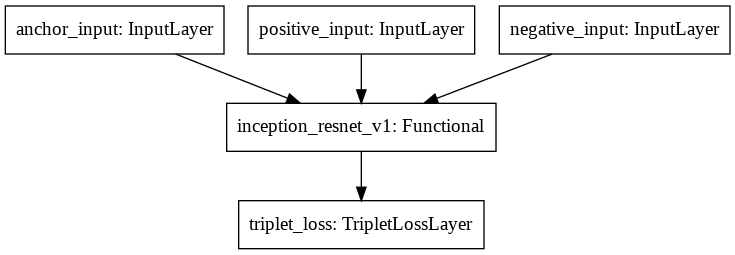

In [ ]:
# Create and compile Trainer model

enc_trainer_model = create_enc_trainer((100,80,3),enc_model,margin = 0.5)
enc_trainer_model.compile(optimizer=Adam(lr=0.0005))

enc_trainer_model.summary()
plot_model(enc_trainer_model,to_file='enc_trainer_model.png')

## 训练

### 方法1

In [ ]:
epochs = 128
random_batch_size = 25
hard_batch_size = 75
batch_size = 64

losses2 = []

for e in range(1,epochs+1):

  mini_batch = get_batch(100)
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses2.append(loss)
  

  if(e%5 == 0):
    print("Triplet Loss after "+str(e)+' epochs : '+str(loss))

e = list(range(epochs+1))

plt.plot(e,losses)
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.title('m1')
plt.show()

NameError: ignored

### 方法2

Triplet Loss after 10 epochs : 41.53315734863281
Triplet Loss after 20 epochs : 27.070777893066406
Triplet Loss after 30 epochs : 19.575923919677734
Triplet Loss after 40 epochs : 17.856056213378906
Triplet Loss after 50 epochs : 16.27602195739746
Triplet Loss after 60 epochs : 11.41118049621582
Triplet Loss after 70 epochs : 8.765586853027344
Triplet Loss after 80 epochs : 11.501953125
Triplet Loss after 90 epochs : 9.07864761352539
Triplet Loss after 100 epochs : 11.021951675415039
Triplet Loss after 110 epochs : 9.097427368164062
Triplet Loss after 120 epochs : 6.319099426269531
Triplet Loss after 130 epochs : 6.135972023010254
Triplet Loss after 140 epochs : 4.851484298706055
Triplet Loss after 150 epochs : 3.8492071628570557
Triplet Loss after 160 epochs : 3.3032591342926025
Triplet Loss after 170 epochs : 4.143660545349121
Triplet Loss after 180 epochs : 3.9514191150665283
Triplet Loss after 190 epochs : 2.2700355052948
Triplet Loss after 200 epochs : 3.380441427230835
Triplet Lo

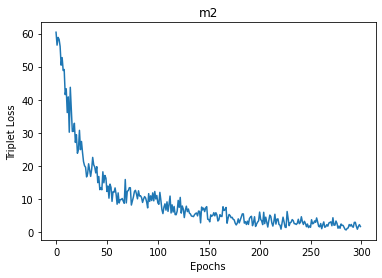

In [ ]:
# Train the Encoder Model using Trainer model

epochs = 300

losses = []

for e in range(1,epochs+1):

  mini_batch = get_batch_randomly(128)
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses.append(loss)

  if(e%10 == 0):
    print("Triplet Loss after "+str(e)+' epochs : '+str(loss))
  
e = list(range(epochs))

plt.plot(e,losses)
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.title('m2')
plt.show()

In [ ]:
# Train the Encoder Model using Trainer model

epochs = 10

# losses = []
K.set_value(enc_trainer_model.optimizer.lr, 0.0002) 

for e in range(1,epochs+1):

  mini_batch = get_batch_randomly(512)
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses.append(loss)

  # if(e%10 == 0):
  print("Triplet Loss after "+str(e+60)+' epochs : '+str(loss))
  
# e = list(range(epochs))

# plt.plot(e,losses)
# plt.xlabel('Epochs')
# plt.ylabel('Triplet Loss')
# plt.title('m2')
# plt.show()

Triplet Loss after 61 epochs : 2.262230396270752
Triplet Loss after 62 epochs : 1.8618441820144653
Triplet Loss after 63 epochs : 2.1970908641815186
Triplet Loss after 64 epochs : 1.3962494134902954
Triplet Loss after 65 epochs : 1.7152667045593262
Triplet Loss after 66 epochs : 2.065243721008301
Triplet Loss after 67 epochs : 1.0519338846206665
Triplet Loss after 68 epochs : 2.1369118690490723
Triplet Loss after 69 epochs : 1.183807134628296
Triplet Loss after 70 epochs : 1.194262981414795


### 方法3

### 方法4

Triplet Loss after 0 epochs : 59.92619705200195
Triplet Loss after 10 epochs : 56.76487350463867
Triplet Loss after 20 epochs : 42.18770217895508
Triplet Loss after 30 epochs : 34.536041259765625
Triplet Loss after 40 epochs : 28.279621124267578
Triplet Loss after 50 epochs : 26.28462791442871
Triplet Loss after 60 epochs : 20.641767501831055
Triplet Loss after 70 epochs : 16.21996307373047
Triplet Loss after 80 epochs : 23.708335876464844
Triplet Loss after 90 epochs : 20.15501594543457
Triplet Loss after 100 epochs : 14.724100112915039
Triplet Loss after 110 epochs : 17.451702117919922
Triplet Loss after 120 epochs : 11.988158226013184
Triplet Loss after 130 epochs : 11.646148681640625
Triplet Loss after 140 epochs : 16.478824615478516
Triplet Loss after 150 epochs : 12.819721221923828
Triplet Loss after 160 epochs : 13.36833381652832
Triplet Loss after 170 epochs : 9.556532859802246
Triplet Loss after 180 epochs : 11.276105880737305
Triplet Loss after 190 epochs : 11.807902336120605

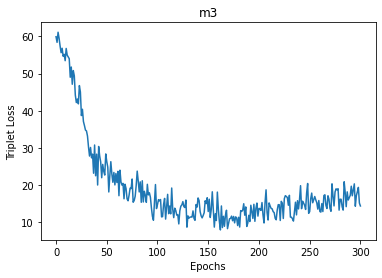

In [ ]:
# Train the Encoder Model using Trainer model

epochs = 300

losses = []

for e in range(epochs+1):

  mini_batch = get_batch_sort()
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses.append(loss)

  if(e%10 == 0):
    print("Triplet Loss after "+str(e)+' epochs : '+str(loss))

  
e = list(range(epochs+1))

plt.plot(e,losses)
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.title('m3')
plt.show()

## Triplet Test


In [ ]:
triplet_test_path = "drive/My Drive/Face_recognation/triplet_batch"
with open(triplet_test_path, 'rb')as f:
  triplet_test_batch = pickle.load(f)

In [ ]:
size_triplet_test_batch = len(triplet_test_batch[0])
pos = 0
for index in range(size_triplet_test_batch): 
  anchor = triplet_test_batch[0][index]
  positive  = triplet_test_batch[1][index]
  negative = triplet_test_batch[2][index]

  anchor_enc  = enc_model.predict(normalize_single(anchor).reshape(1,100,80,3))
  positive_enc  = enc_model.predict(normalize_single(positive).reshape(1,100,80,3))
  negative_enc  = enc_model.predict(normalize_single(negative).reshape(1,100,80,3))

  ap = distance(anchor_enc,positive_enc)
  an = distance(anchor_enc,negative_enc)

  if ap<an:
    pos += 1
print("accuracy:",pos/size_triplet_test_batch)

accuracy: 0.9833333333333333


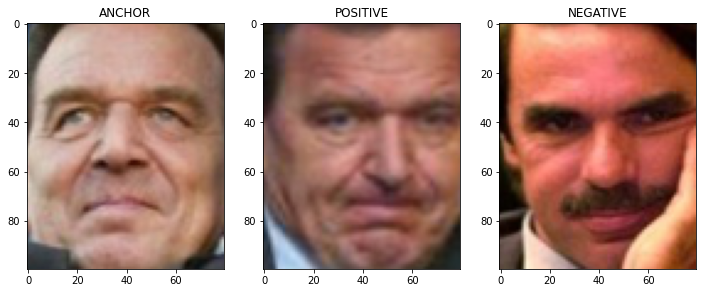

Distance between Anchor and Positive : 1.145405
Distance between Anchor and Negative : 1.8636897


In [ ]:
# Visualize Triplets with positive and negative distances

index = np.random.randint(size_triplet_test_batch)

anchor = triplet_test_batch[0][index]
positive  = triplet_test_batch[1][index]
negative = triplet_test_batch[2][index]

plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.imshow(anchor)
plt.title('ANCHOR')
plt.subplot(1,3,2)
plt.imshow(positive)
plt.title('POSITIVE')
plt.subplot(1,3,3)
plt.imshow(negative)
plt.title('NEGATIVE')

plt.show()

anchor_enc  = enc_model.predict(normalize_single(anchor).reshape(1,100,80,3))
positive_enc  = enc_model.predict(normalize_single(positive).reshape(1,100,80,3))
negative_enc  = enc_model.predict(normalize_single(negative).reshape(1,100,80,3))

print("Distance between Anchor and Positive : "+str(distance(anchor_enc,positive_enc)))
print("Distance between Anchor and Negative : "+str(distance(anchor_enc,negative_enc)))

## 测试

In [ ]:
card_loc = "drive/My Drive/Face_recognation/cards"
test_loc = "drive/My Drive/Face_recognation/test_batch_seen_cropped"

with open(card_loc, 'rb')as f:
  cards = pickle.load(f)
with open(test_loc, 'rb')as f:
  test_batch = pickle.load(f)

In [ ]:
def card2batch(cards):
  labels = []
  names = []
  faces = []
  for card in cards:
    for label,(name,face) in card.items():
      labels.append(label)
      names.append(name)
      faces.append(face)
  return [labels, names, faces]

In [ ]:
card_batch = card2batch(cards)

In [ ]:
def yanzheng(card, test_batch, margin=0.5):
  size_test = len(test_batch['label'])
  pos = 0
  for i in range(size_test):
    idcard = card[2][i]
    pic = test_batch['faces'][i]

    anchor_enc  = enc_model.predict(normalize_single(idcard).reshape(1,100,80,3))
    enc  = enc_model.predict(normalize_single(pic).reshape(1,100,80,3))

    d = distance(anchor_enc,enc)
    # print(d)
    if d<margin:
      pos+=1

  return pos/size_test

In [ ]:
acc = yanzheng(card_batch, test_batch)
acc

0.09540636042402827

In [ ]:
testunseen_loc = "drive/My Drive/Face_recognation/test_batch_unseen_cropped"
with open(testunseen_loc, 'rb')as f:
  test_unseen = pickle.load(f)

In [ ]:
def yanzheng2(test_batch, margin=0.5):
  size_test = 849
  pos = 0
  for i in range(size_test):
    picA = test_batch[i*2]
    picB = test_batch[i*2+1]

    encA  = enc_model.predict(normalize_single(picA).reshape(1,100,80,3))
    encB  = enc_model.predict(normalize_single(picB).reshape(1,100,80,3))

    d = distance(encA,encB)
    # print(d)
    if d<margin:
      pos+=1

  return pos/size_test

In [ ]:
acc_unseen=yanzheng2(test_unseen['faces'])
acc_unseen

0.2767962308598351

#### 计算top5准确率

In [ ]:
label, name, faces = card_batch
size_card = len(label)
card_embedded = []
for i in range(size_card):
  enc  = enc_model.predict(normalize_single(faces[i]).reshape(1,100,80,3))
  card_embedded.append(enc)

In [ ]:
# 返回 5% label
def recognize(anchor, card_embedded, ntop5=5):
  size_card = len(card_embedded)
  res = {}
  anchor_enc  = enc_model.predict(normalize_single(anchor).reshape(1,100,80,3))
  for i in range(size_card):
    enc  = card_embedded[i]
    tp = distance(anchor_enc,enc)
    res[i]=tp
  res_sorted = sorted(res.items(), key = lambda item:item[1])
  # print(res_sorted[:5])
  predicted = []
  i = 0
  for k,v in res_sorted:
    if i==ntop5: break
    predicted.append(k)
    i+=1
  return predicted

In [ ]:
def calcacc(curlabel, predicted_label, ntop1=1, ntop3=3, ntop5=5):
  index = 0
  # print(curlabel,predicted_label)
  for label in predicted_label:
    if label == curlabel:
      break
    index += 1
  # print(index)
  if index < ntop1:
    return [1,1,1]
  if index < ntop3:
    return [0,1,1]
  if index < ntop5:
    return [0,0,1]
  return [0,0,0]

In [ ]:
def evaluate(test_batch, card_embedded):
  size_test = len(test_batch['label'])
  top1, top3, top5 = 0, 0, 0
  for i in range(size_test):
    curlabel = test_batch['label'][i]
    curface = test_batch['faces'][i]
    predicted_label = recognize(curface, card_embedded)
    acc = calcacc(curlabel,predicted_label)
    top1 += acc[0]
    top3 += acc[1]
    top5 += acc[2]
  return [top1/size_test,top3/size_test,top5/size_test]

In [ ]:
result = evaluate(test_batch, card_embedded)
print('top1:',result[0])
print('top3:',result[1])
print('top5:',result[2])

top1: 0.045936395759717315
top3: 0.10247349823321555
top5: 0.13074204946996468


## 保存模型

In [ ]:
# Save the encoder model weights for future use

save_location = "drive/My Drive/Face_recognation/enc_model_weights_my_m4.h5"
enc_model.save_weights(save_location)